# Create & evaluate synthetic data

This notebook demonstrates how to create a synthetic data generator, use it to generate synthetic data and evaluate the utility of the synthetic data for predictive modeling.
<br><br>

## Load and prepare the data

In [178]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load data
data = pd.read_csv('adult-subset-for-synthetic.csv')

# Initialize label encoder
label_encoder = LabelEncoder()

# Encode the target variable
data['salary-class'] = label_encoder.fit_transform(data['salary-class'])

# Split data into features and target
X = data.drop('salary-class', axis=1)
y = data['salary-class']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2210585030)

## Create and train the Gaussian Copula Model

In [179]:
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

# Automatically infer metadata from the DataFrame
metadata = SingleTableMetadata()

# Combine X_train and y_train for Gaussian Copula
train_data = pd.concat([X_train, y_train], axis=1)
metadata.detect_from_dataframe(data=train_data)

# Create and train the Gaussian Copula model
model = GaussianCopulaSynthesizer(metadata)
model.fit(train_data)

## Generate synthetic data

In [180]:
synthetic_data = model.sample(len(train_data))

## Compare original and synthetic data

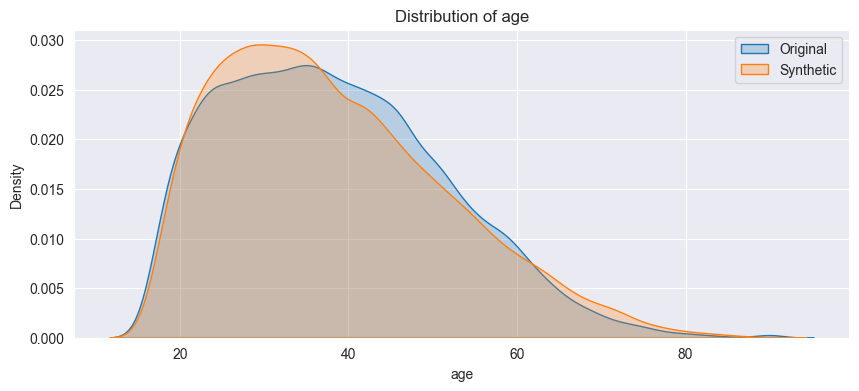

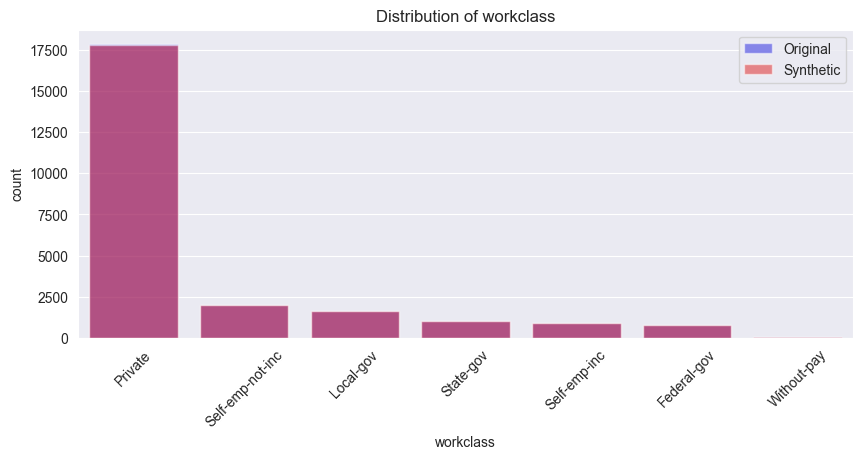

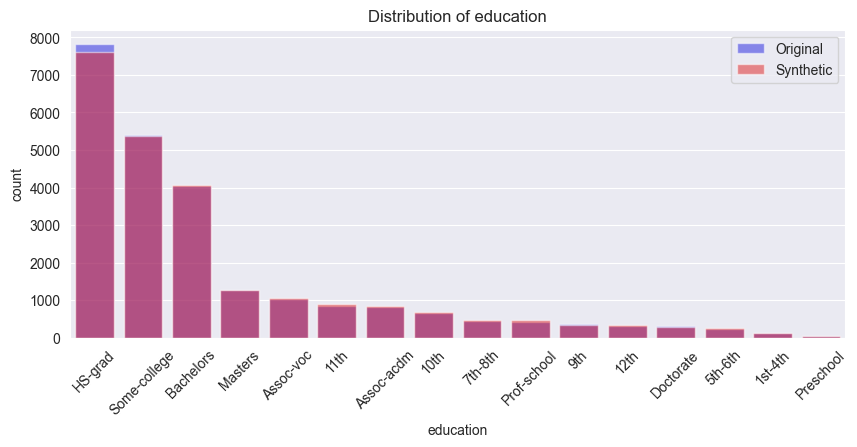

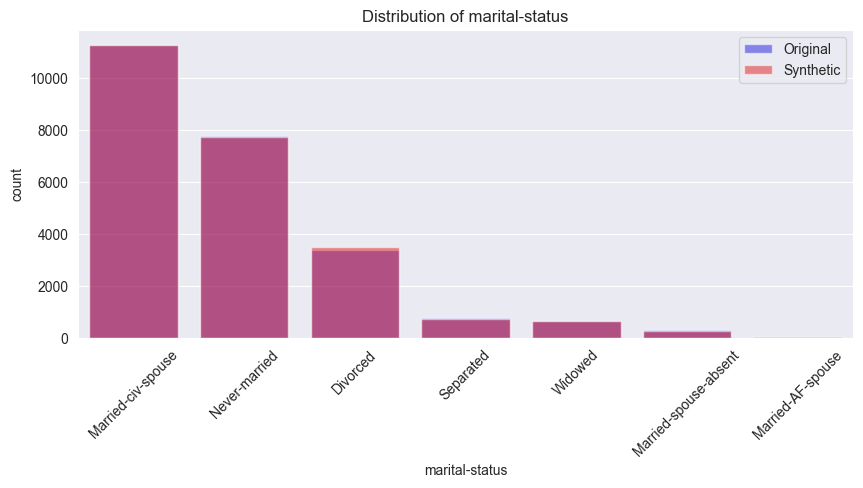

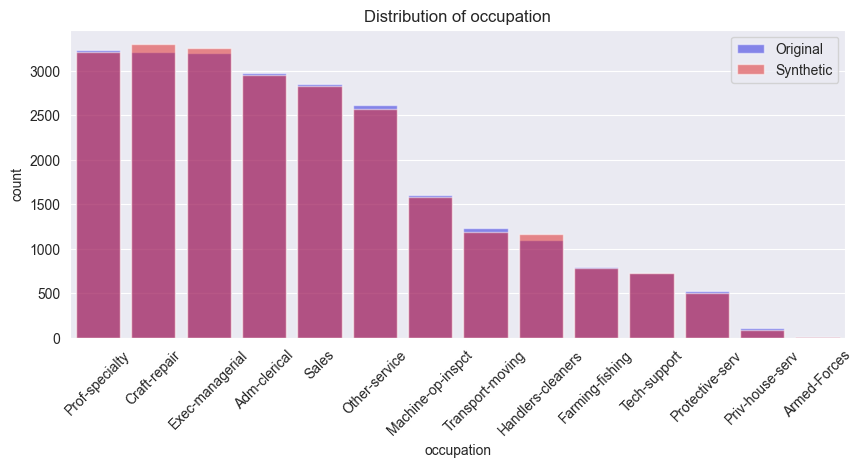

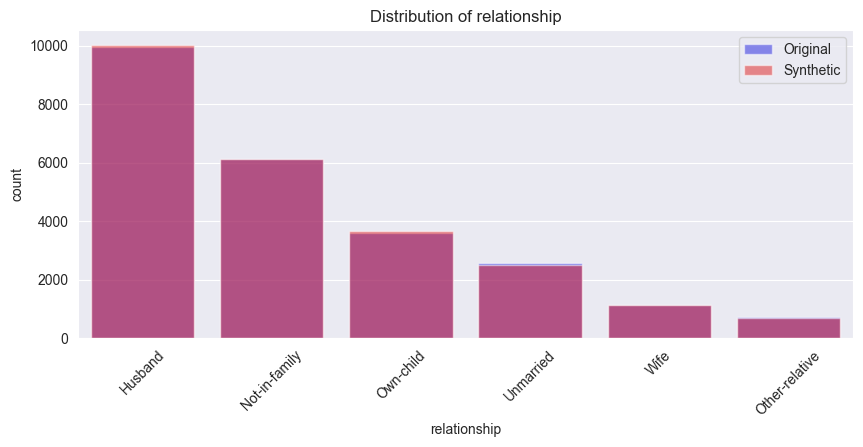

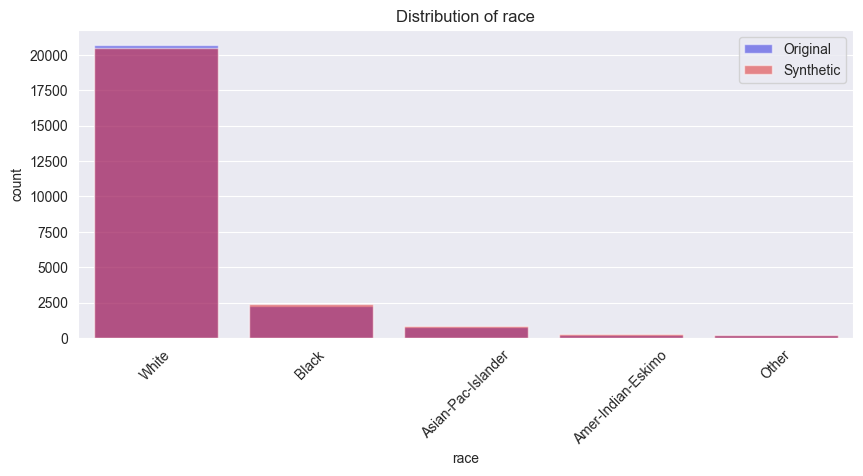

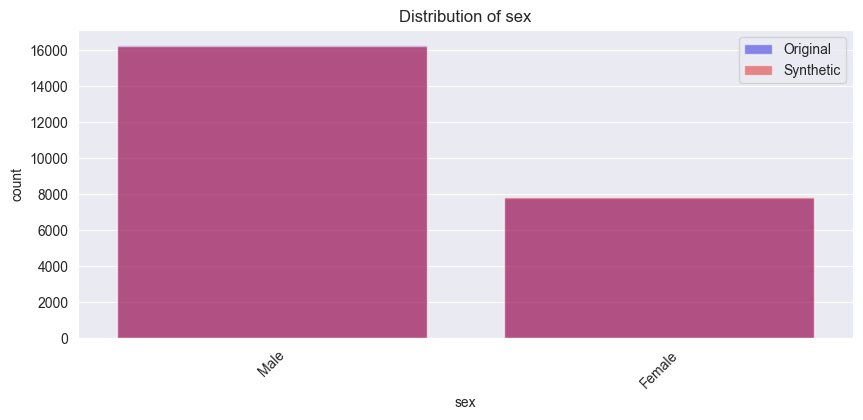

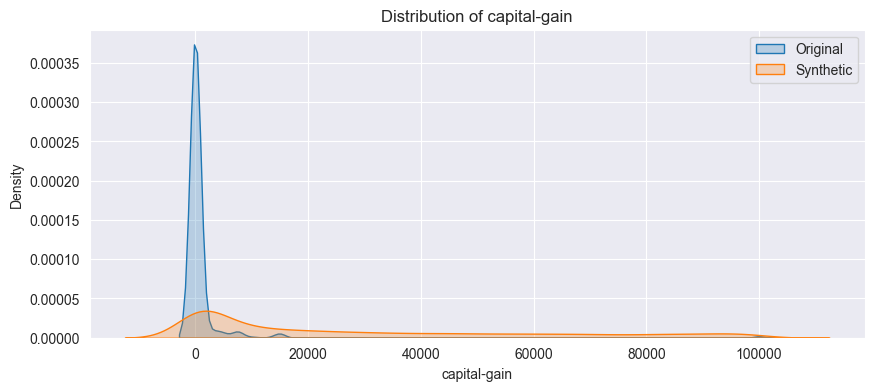

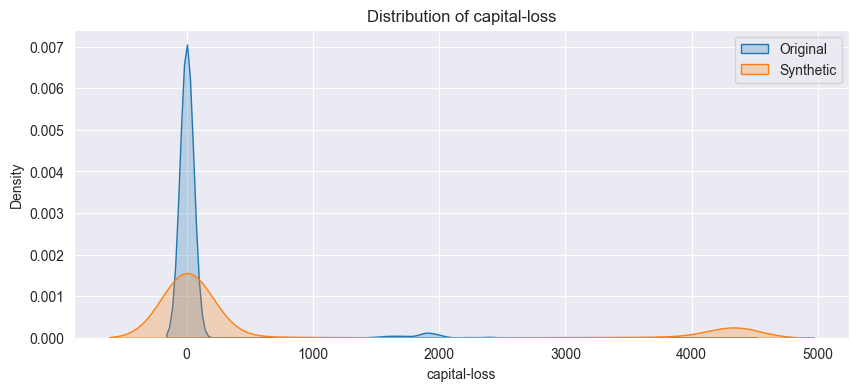

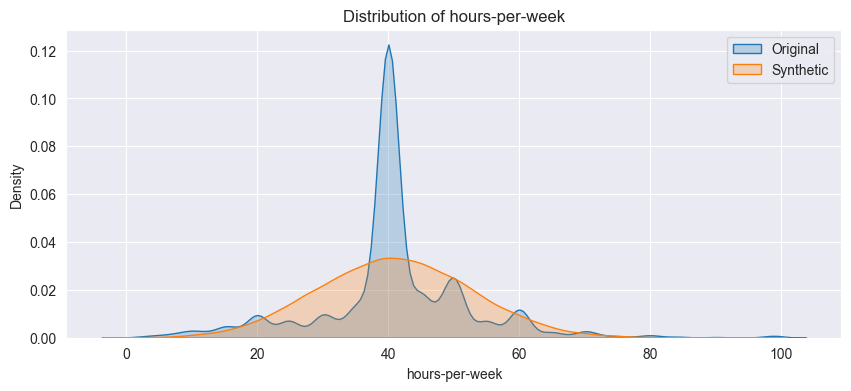

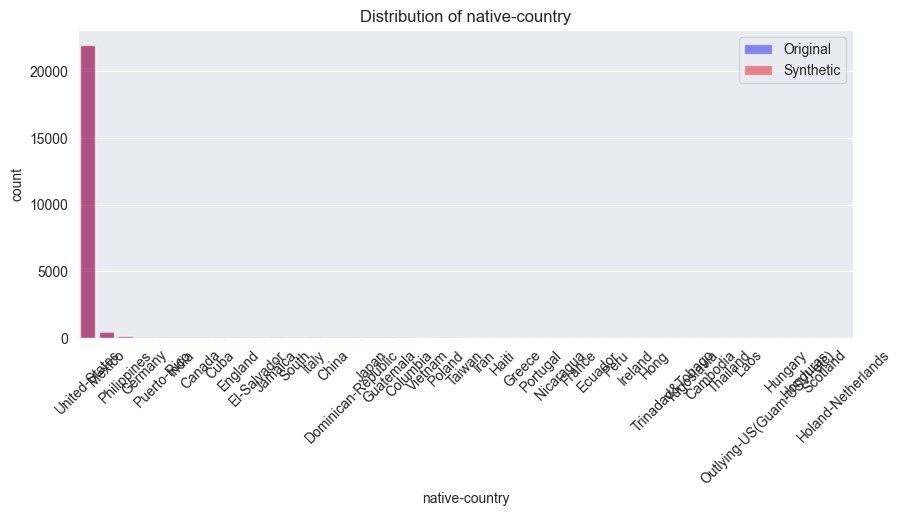

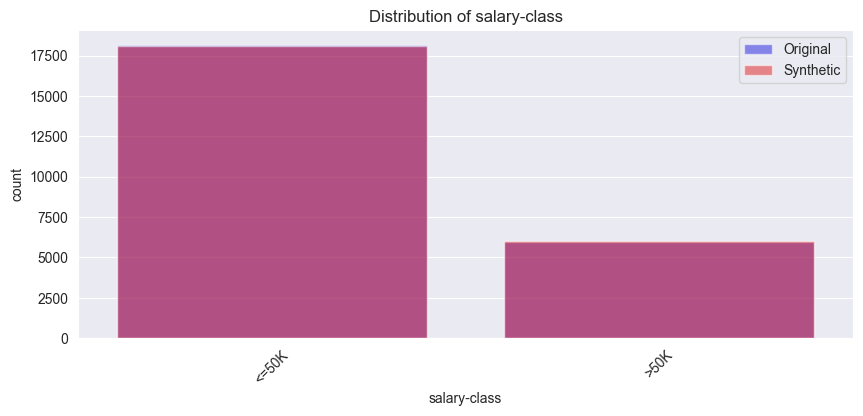

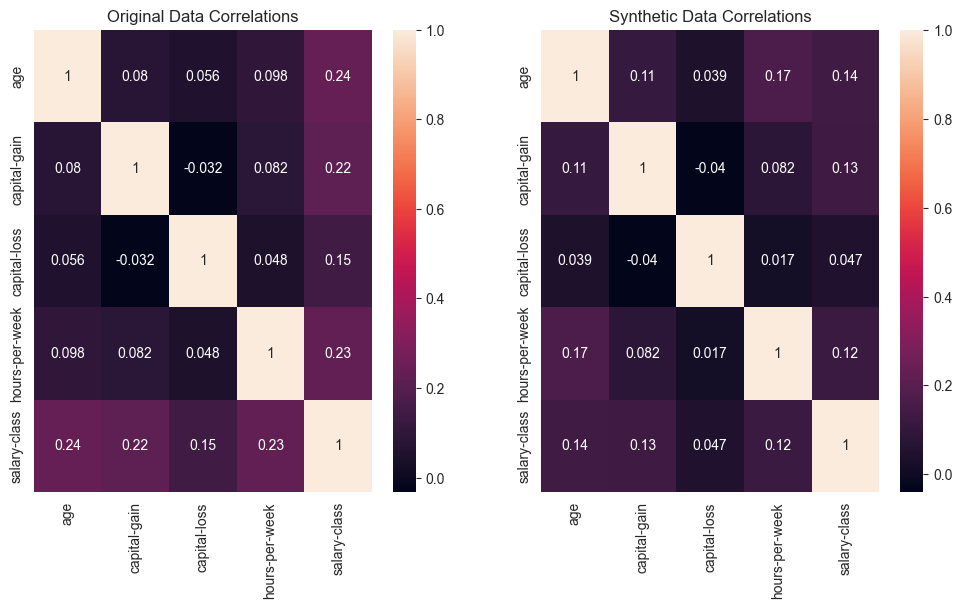

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compare distributions for all columns
for column in train_data.columns:
    plt.figure(figsize=(10, 4))

    # Define the order for consistent plotting
    order = train_data[column].value_counts().index

    # For categorical data, use count plot
    if train_data[column].dtype == 'object' or column == 'salary-class':
        sns.countplot(x=column, data=train_data, order=order, color='blue', alpha=0.5, label='Original')
        sns.countplot(x=column, data=synthetic_data, order=order, color='red', alpha=0.5, label='Synthetic')

        # If the column is salary-class, use the inverse_transform to get original labels
        if column == 'salary-class':
            class_labels = label_encoder.inverse_transform(sorted(train_data['salary-class'].unique()))
            plt.xticks(ticks=range(len(class_labels)), labels=class_labels)

        plt.xticks(rotation=45)

    # For continuous data, use KDE plot
    else:
        sns.kdeplot(train_data[column], label='Original', fill=True)
        sns.kdeplot(synthetic_data[column], label='Synthetic', fill=True)

    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()
    
# Calculate correlation matrices
original_corr = train_data.corr(numeric_only=True)
synthetic_corr = synthetic_data.corr(numeric_only=True)

# Plot heatmaps of the correlations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(original_corr, annot=True)
plt.title('Original Data Correlations')

plt.subplot(1, 2, 2)
sns.heatmap(synthetic_corr, annot=True)
plt.title('Synthetic Data Correlations')

plt.show()

## Statistical tests for distribution comparison

In [182]:
from scipy.stats import ks_2samp

for column in train_data.columns:
    ks_stat, ks_p_value = ks_2samp(train_data[column], synthetic_data[column])
    print(f"{column} - KS Statistic: {ks_stat}, P-Value: {ks_p_value}")

age - KS Statistic: 0.026026772763065087, P-Value: 1.5645404044820224e-07
workclass - KS Statistic: 0.0016577562269467494, P-Value: 0.9999999999999983
education - KS Statistic: 0.00969787392763899, P-Value: 0.20523156264818931
marital-status - KS Statistic: 0.00414439056736704, P-Value: 0.985183445392662
occupation - KS Statistic: 0.007418459115587084, P-Value: 0.5178194810610555
relationship - KS Statistic: 0.004227278378714394, P-Value: 0.9817356450736275
race - KS Statistic: 0.00940776658792325, P-Value: 0.2345180698805932
sex - KS Statistic: 0.002030751378009843, P-Value: 0.9999999997362946
capital-gain - KS Statistic: 0.9004102946661693, P-Value: 0.0
capital-loss - KS Statistic: 0.2404160968129636, P-Value: 0.0
hours-per-week - KS Statistic: 0.2315885449044718, P-Value: 0.0
native-country - KS Statistic: 0.0012847610758837946, P-Value: 1.0
salary-class - KS Statistic: 0.0026109660574412663, P-Value: 0.9999968953082436


## Preprocess data for modeling

In [183]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Preprocess original and synthetic data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
synthetic_data_processed = preprocessor.transform(synthetic_data.drop('salary-class', axis=1))
synthetic_target = synthetic_data['salary-class']

## Train logistic regression and decision tree models

In [184]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

# Initialize models
lr = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier()

# Dictionary to store performance metrics
performance_metrics = {
    'Original Data': {},
    'Synthetic Data': {}
}

# Evaluate models and store metrics
for model in [lr, dt]:
    # Train on original data and store metrics
    model.fit(X_train_processed, y_train)
    original_predictions = model.predict(X_test_processed)
    performance_metrics['Original Data'][model.__class__.__name__] = {
        'Accuracy': accuracy_score(y_test, original_predictions),
        'F1': f1_score(y_test, original_predictions, average='macro'),
        'ROC AUC': roc_auc_score(y_test, original_predictions),
        'Precision': precision_score(y_test, original_predictions, average='binary'),
        'Recall': recall_score(y_test, original_predictions, average='binary')
    }

    # Train on synthetic data and store metrics
    model.fit(synthetic_data_processed, synthetic_target)
    synthetic_predictions = model.predict(X_test_processed)
    performance_metrics['Synthetic Data'][model.__class__.__name__] = {
        'Accuracy': accuracy_score(y_test, synthetic_predictions),
        'F1': f1_score(y_test, synthetic_predictions, average='macro'),
        'ROC AUC': roc_auc_score(y_test, synthetic_predictions),
        'Precision': precision_score(y_test, synthetic_predictions, average='binary'),
        'Recall': recall_score(y_test, synthetic_predictions, average='binary')
    }

## Evaluate model performance

In [185]:
for metric in ['Accuracy', 'F1', 'ROC AUC', 'Precision', 'Recall']:
    print(f"Utility Loss - {metric}:")
    for model_name in performance_metrics['Original Data']:
        original_metric = performance_metrics['Original Data'][model_name][metric]
        synthetic_metric = performance_metrics['Synthetic Data'][model_name][metric]
        utility_loss = original_metric - synthetic_metric
        print(f"  {model_name}: {utility_loss:.4f}")
    print()

Utility Loss - Accuracy:
  LogisticRegression: 0.0834
  DecisionTreeClassifier: 0.1351

Utility Loss - F1:
  LogisticRegression: 0.3253
  DecisionTreeClassifier: 0.2486

Utility Loss - ROC AUC:
  LogisticRegression: 0.2340
  DecisionTreeClassifier: 0.2244

Utility Loss - Precision:
  LogisticRegression: 0.4614
  DecisionTreeClassifier: 0.4029

Utility Loss - Recall:
  LogisticRegression: 0.5436
  DecisionTreeClassifier: 0.4080


## Analysis
<br>

### Statistical tests

#### Age

The low KS statistic suggests the age distributions are quite similar, but the very low P-value indicates this similarity is statistically significant, meaning there are some differences between the original and synthetic distributions.
<br><br>

#### Work class, education, marital status, occupation, relationship, race, sex, native country, salary class

These attributes show a high degree of similarity between the original and synthetic distributions, as indicated by low KS statistics and high P-values (indicating no significant difference).
<br><br>

#### Capital gain, capital loss, hours-per-week

These attributes show a significant difference between the original and synthetic distributions. The high KS statistic and low P-value indicate that the synthetic data does not closely match the original data for these variables.
<br><br><br>

### Metrics

#### Accuracy

Both models show a decrease in accuracy when trained on synthetic data. The logistic regression model exhibits a lower utility loss compared to the decision tree, indicating it may be more robust to the differences in the synthetic data.
<br><br>

#### F1 Score

The F1 score, which balances precision and recall, also decreases for both models. The lower utility loss in the decision tree model suggests that it may better maintain the balance between precision and recall with synthetic data.
<br><br>

#### ROC AUC

The decrease in ROC AUC for both models indicates a reduced ability to distinguish between classes with synthetic data. The similar utility loss for both models suggests a comparable impact on their classification capabilities.
<br><br>

#### Precision

 Precision decreases significantly in both models, more so in logistic regression. This suggests that synthetic data leads to more false positives, particularly for logistic regression.
<br><br>
 
#### Recall

The recall also decreases for both models, indicating that synthetic data results in more false negatives. The higher decrease in logistic regression suggests that it misses more actual positives than the decision tree.
<br><br>

### Overall

* The synthetic data generated using the Gaussian Copula model has varying degrees of resemblance to the original data, with some attributes showing high similarity and others showing significant differences.
* The utility loss in predictive modeling indicates that while synthetic data can be used for training models, there is a noticeable drop in performance. This should be considered, especially in applications where precision and recall are crucial.
* The logistic regression model seems more affected by the synthetic data than the decision tree in terms of precision and recall, but less affected in terms of accuracy and F1 score.